# Recognizing Handwritten Digits with the k-Nearest Neighbour Classification Algorithm

## 1. Introduction:

In this notebook, I will delve into the world of k-NN classification algorithm - one of the most popular and effective supervised learning techniques. Despite its simplicity, k-NN has proven to be a powerful tool for classification tasks in a variety of domains, ranging from image recognition to natural language processing.

### 1.1. Purpose of Conducting
However, implementing k-NN classifier is not a straightforward process and often poses several challenges. The most common concerns are determining the optimal value of k, selecting the appropriate distance metric, handling imbalanced datasets, and dealing with high-dimensional data. To address these challenges, I will conduct hyperparameter tuning on two key parameters: k neighbors and distance metrics. By optimizing these parameters, we may achieve better classification performance and improve the accuracy of our k-NN classifier. Moreover, we also implemented a weighted k-NN algorithm for MNIST database.
### 1.2. Experiment Design
One of the main challenges in k-NN is choosing the optimal number of neighbors (k) and distance metric. That's why I will conduct two experiments to find the optimal value of k and the best distance metrics for our classifier.
* Experiment 1: Optimal k neighbors value In this experiment, I will vary the value of k and measure the accuracy of our model for each k value to determine the optimal k neighbors value.
* Experiment 2: Distance Metrics In this experiment, we I explore three different distance metrics to calculate the distance between data points: Manhattan, Minkowski, and Cosine. I will compare the accuracy of our model for each distance metric to determine the best distance metric for our classifier.
* Experiment 3: Implement a weighted k-NN algorithm.

## 2. Data Processing:

### 2.1. MNIST Database
The MNIST database is a database of 60,000 images of handwritten digits from 0 through 9 with numerical labels. This is commonly used for training various image processing systems and testing in the field of machine learning. To the right is a sample of labeled images included in the database [5].
![MnistExamples.png](attachment:MnistExamples.png)
**Image source: [5]**

### 2.2. Import Libraries

In [1]:
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import gzip
from numpy import linalg as LA

### 2.3. Downloading MNIST Files

In [2]:
mnist_url = "http://yann.lecun.com/exdb/mnist/"
img_file = "train-images-idx3-ubyte.gz"
labels_file = "train-labels-idx1-ubyte.gz"

In [3]:
def get_MNIST():
    """
    This is the function for downloading MNIST files where 'images' returns images of digits and 
    'label' gives the corresponding labels of images. 
    
    """
    for fname in [img_file, labels_file]:
        if Path(fname).is_file() :
            print(f"Found: {fname}")
            continue
        r = requests.get(mnist_url + fname)
        with open(fname, 'wb') as foo:
            foo.write(r.content)
            
    with gzip.open(img_file, 'rb') as foo:
         f = foo.read()
    with gzip.open(labels_file, 'rb') as foo:
         g = foo.read()
    images = np.array([b for b in f[16:]]).reshape(-1, 28*28)
    labels = np.array([b for b in g[8:]])
    
    return images,labels

The images are grayscale and have a resolution of 28 x 28 pixels, resulting in a total of 784 pixels per image. Each pixel is represented by a value between 0 and 255, with higher values indicating darker shades. The dataset also includes labels for each image, indicating the true digit that the image represents.

In [4]:
images,labels = get_MNIST()

Found: train-images-idx3-ubyte.gz
Found: train-labels-idx1-ubyte.gz


In [5]:
print("Images shape: ", np.shape(images))
print("Lables shape: ", np.shape(labels))

Images shape:  (60000, 784)
Lables shape:  (60000,)


The `image` dataset has 60000 rows and 784 columns where each row represents a image of a single digit and labels is a 
1-diemnsional Numpy array which has 60000 entries each of them corresponds to the label of the digits in the images array.

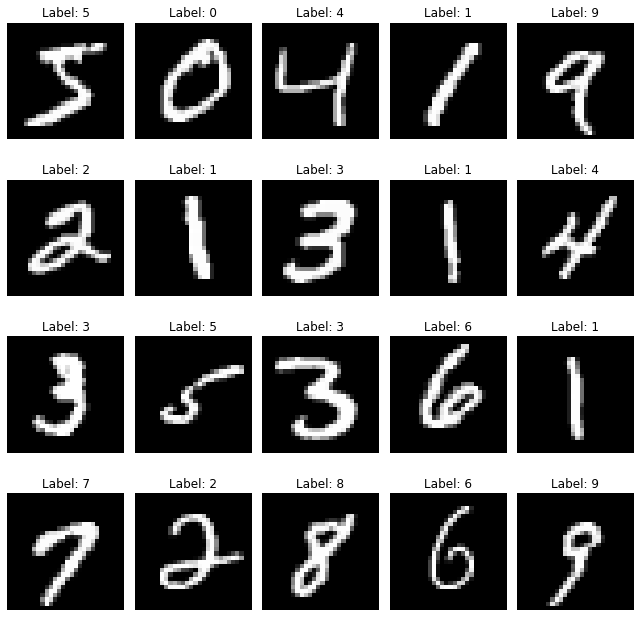

In [6]:
# Display 20 images with theirs labels 
num_images=20

fig, axes = plt.subplots(nrows=4, ncols=num_images//4, figsize=(9, 9))

# Display num_images//nrows images per row, i is the index f current image being plotted 
for i in range(num_images):
  # row index of current image in the subplot grid 
  i_row = i // (num_images//4)
  # column index of current image in the subplot grid
  i_col = i % (num_images//4)
  ax = axes[i_row, i_col]
  ax.imshow(images[i].reshape(28,28), cmap='gray')
  ax.set_title("Label: {}".format(labels[i]))
  ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Implement k-Nearest Neighbor Algorithm:

The k-Nearest Neighbors (KNN) algorithm is a simple yet powerful classification and regression technique in machine learning. It operates based on the assumption that similar data points tend to share similar outcomes. In a nutshell, when tasked with classifying a new data point, KNN looks at its `k` nearest neighbors in the training data and assigns the new point the class label that the majority of its neighbors possess.

We can implement this algorithm as follows:

1. Calculate the distance between the new data point and all existing data points in the training dataset.
2. Select the `k` data points with the shortest distances.
3. Determine the most frequent class label among these `k` neighbors.
4. Assign the new data point the class label that appeared most frequently.

**Advantages of KNN:** 

- Easy to understand and implement
- Non-parametric: KNN doesn't make assumptions about the underlying data distribution, making it suitable for a wide range of data types and shapes of decision boundaries.
- Adaptability: KNN can adapt to changes in data without needing to retrain the entire model, making it useful for dynamic or evolving datasets.
- Flexibility: KNN can be used for both classification and regression tasks.
- Interpretable: The results of KNN can be easily interpreted and visualized, aiding in understanding the decisions made by the model.

**Disadvantages of KNN:**

- Computational Complexity: KNN's prediction time can increase significantly as the dataset grows, since it requires calculating distances for every point in the training set.
- Sensitive to Irrelevant Features: If the dataset has many irrelevant features, the distance calculation can be skewed, leading to poor predictions.
- Choosing `k`: Selecting the right value for `k` is crucial. A small `k` can make the model sensitive to noise, while a large `k` may lead to oversmoothing.
- Imbalanced Data: In datasets with imbalanced class distributions, KNN might favor the majority class due to the influence of nearby neighbors.

### 3.1. Distance Function

To use k-NN classification method, it is necessary to measure distance between the training dataset and the selecting testing dataset. There are various ways to measure distance.


1. **$L_p$ distance**: The $L_p$ distance between two points $\mathbf{x}=(x_1, x_2, ..., x_n)$ and $\mathbf{y}=(y_1, y_2, ..., y_n)$ is defined by 
      $$L_p(\mathbf{x, y})=\sqrt[p]{\sum_{i=1}^{n} (x_i-y_i)^p}$$
The $L_p$ distance is a general form of distance.

2. **Manhattan distance or $L_1$ distance**: This distance is the gridwise measure in the space between two points $\mathbf{x}=(x_1, x_2, ..., x_n)$ and $\mathbf{y}=(y_1, y_2, ..., y_n)$ which is defined by
$$L_1(\mathbf{x, y})=\sum_{i=1}^{n} |x_i-y_i|$$
    
3. **Euclidean distance or $L_2$ distance**:  It measures the distance between two points namely $\mathbf{x}=(x_1, x_2, ..., x_n)$ and $\mathbf{y}=(y_1, y_2, ..., y_n)$ in Euclidean space,  $\mathbb{R}^n$ which is basically the length of a line segment between the two points. So,
$$L_2(\mathbf{x, y})=\sqrt{\sum_{i=1}^{n} (x_i-y_i)^2}$$


4. **Chebyshev distance or $L_\infty$ distance or uniform distance**: This distance is related to the uniform norm and measured by 
$$L_{\infty}(\mathbf{x, y})=\max_{i=1} {|x_i-y_i|}$$


Here, is the code for in genral $L_p$ distance formula. In this project, we used $L_p$ distance and varies the value of $p$. 

In [7]:
def lp_distance(x,w):
    """
    This is the fucntion for measuring $L_p$ distance formula which takes two arguments and return the distance.
    
    The two arguments are:
    
    x:
      a 2-dimensional Numpy array 
    
    w:
       a 1-dimensional Numpy array 
              
    Returns:
    
    distance:
            a 1-dimensional Numpy array whose i-th entry
            is the L_p distance between i-th row of x and w
    
    """
    distance = np.power(np.sum((np.abs(x-w))**p, axis=1), (1/p))
    
    return distance

### 3.2. k-NN Classifier Model:

This is the code for k-NN method by using the distance function and it will take as a argument the training dataset, labels of training dataset, a test point which label will be predicted and an integer $n$ which defines the number of nearest neighboring training data points and will give us the predicted label of the test datapoint with the number of the nearest neighbour points and the label of nearest neighbour points. 

In [8]:
def knn_classifier(training_data,training_label, x, n):
    """
    This is the fucntion for  k-nearest neighbors (k-NN) algorithm which takes four arguments and returns a tuple.
    
    The four arguments are:
    
    training_data:
                a 2-dimensional Numpy array in which each row is one element of the training data. 
              
    training_label: 
                a 1-dimensional Numpy array with labels of the training data: the k-th element of this array 
                is the label corresponding to the k-th row of training_data. 
                
        x:  
            a 1-dimensional Numpy array with a data point we want to classify. 
            
        n: 
            an integer specifying the number of neighbors to use for the classification.
        
   Returns:
   
   label:  
         the predicted label of the point x 
         
   neighbour: 
          a list of rows numbers of training_data which are the n nearest neighbours of x.
          
   nearest_neighbour_label:
          a list of rows numbers of label of training_data which are the n nearest neighbours of x
        
            
    """
    
    # Calcualte the distance between the test data and training data
    distance = lp_distance(x,training_data) 
    # Order the index of distance
    nearest_neighbour = distance.argsort()[:n] 
    # Select n neartest neighbour data from test data 
    nearest_neighbour_data = training_data[nearest_neighbour[0:n]] 
    # Label of n neartest neighbour data
    nearest_neighbour_label = training_label[nearest_neighbour[0:n]] 
    # Label which occurs maximum time
    label = np.bincount(nearest_neighbour_label).argmax() 

    return nearest_neighbour, label, nearest_neighbour_label

### 3.3. Model Implementation:
Now, we implement the KNN classifier for the given dataset

**1. Data splitting**: 


For model implementation we need to spllit the dataset into training and test dataset. Among 60,000 images randomly choose 20000 images as training data and 10000 images as testing data. And for implementing the model, we use $L_2$ distance that means $p=2$. At first, the images shuffled randomly then 1st 20000  data points seleceted as training dataset with the corresponding labels and then 10000 data points seleceted as test dataset. 

In [9]:
# Randomly ordered index
rng = np.random.default_rng(200) 
reorder = rng.permutation(len(images))
# Shuffling images
images = images[reorder] 
# Shuffling labels
labels = labels[reorder] 

In [10]:
training_data = 20000
testing_data = 10000

# Select training images
training_images = images[:training_data] 
# Select training images labels 
training_labels = labels[:training_data] 
# Select test images 
test_images = images[training_data:training_data+testing_data] 
# Select test images label 
test_labels = labels[training_data:training_data+testing_data] 

In [11]:
training_images.shape, training_labels.shape, test_images.shape, test_labels.shape

((20000, 784), (20000,), (10000, 784), (10000,))

**2. Predict the label of test data:**


Now apply the model to predict the label of test data. Initially for $n=5$, the model gives us the label of the test point with these five neighbours.  

In [ ]:
test_number=1999
p=2
nearest_neighbour, label, nearest_neighbour_label  = knn_classifier(training_images, 
                                                                     training_labels, 
                                                                     test_images[test_number], 
                                                                     n=5)
    
print("Predicted label for the test data is:", label)
print("The five nearest neighbors are:", nearest_neighbour)
print("The labels of five nearest neighbors are:", nearest_neighbour_label)

We see that the label of the test data and three nearest neighbour is same i.e 3. To check that the prediction iss correct, let find the actual label of the test image.

In [ ]:
plt.imshow(test_images[test_number].reshape(28,28),cmap="Greys")
plt.title(test_labels[test_number])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The predicted label is similar to actual label. So the prediction is correct. So far we could find the class of a single data point. 
This function is defined only for predicting the class of a single input data point. For the prediction of a whole data set later we use this function in another function. Now we define some function to get the class of a full data set and accuracy measurement.

**3. Accuracy of prediction:**

Our k-NN model can predict the result for only a single data point. For calculating the accuracy percentage we need a number of test data points and their predicted class by the knn_classifier function.  Now we define a function which will take a set of test images without labels and will assign labels to them by using the knn_classifier function. This function also gives the nearest k-neighbors for each test point.

In [ ]:
def getting_actual_labels(training_set, train_labels, test_set, n, method=knn_classifier):
    """
    This is the function for k-nearest neighbors (KNN)  model for a set of test data which takes five arguments 
    and returns a tuple.
    
    The five arguments are:
        training_set:
                    a 2-dimensional Numpy array whose every row represents a training data set.
        train_labels:
                     a 1-dimensional Numpy array whose entries represent labels of the training data.
        test_set: 
                a 2-dimensional Numpy array whose each row represents a test data point.
        n : 
            an integer specifying the number of neighbors to use for the classification.
        method:
              we used knn_classifier method for this function.
            
   
   Returns:
        predicted_labels:
                       a list of labels for the test dataset.
        k_neighbors:
                   a list of lists whose each list represets the row number of for the corresonding 
                    test data point.
    """
    # Empty list for the predicted labels
    predicted_labels = [] 
    # Empty list for k-nearest neighbors
    k_neighbors = [] 
    
    for x in range(len(test_set)):
        result = method(training_set, train_labels, test_set[x], n) 
        predicted_labels.append(result[0])
        k_neighbors.append(result[1])
        
    return predicted_labels, k_neighbors

In [ ]:
def percentage_accuracy(actual_labels, predicted_labels):
    """
    This is the funcition for finding the percentage fraction of test dataset predicted correctly 
    which has two argumanets and returns the accuracy.
    
    
    The two arguments are:
        actual_labels:
                     a 1-dimensional Numpy array whose each entry is a actual label of the test dataset.
        predicted_labels: 
                     a 1-dimensional Numpy array whose each entry is predicted label by knn_classifier.
        
    Returns:
        accuracy: 
                a real number percentage of the predicted labels which are correctely predicted.
    """
    
    accuracy = sum(predicted_labels==actual_labels)/len(actual_labels)*100
    
    return accuracy

In [ ]:
#predict the label of set of data points
k_neighbors, predicted_labels = getting_actual_labels(training_set=training_images,
                                                      train_labels=training_labels,
                                                      test_set=test_images, n=5, 
                                                      method=knn_classifier) 

percentage_accuracy(actual_labels=test_labels, predicted_labels=predicted_labels) 

accuracy = percentage_accuracy(actual_labels=test_labels, predicted_labels=predicted_labels)
print("The accuracy of the k-NN classifier model for three nearest neighbours and L2 distance is ", accuracy, "percent.")

**4. Confusion Matrix to visualize classification accuracy:**

In [ ]:
c=np.zeros((10,10), dtype=int)
for i in range(len(test_labels)):
    c[predicted_labels[i], test_labels[i]]+=1
print(f"Confusion matrix: \n {c}")

In [ ]:
plt.figure(figsize=(12, 12))
value_counts = ["{0:0.0f}".format(value) for value in
                c.flatten()]
percentages = ["{0:.2%}".format(per) for per in
                     (c/np.sum(c, axis=1)).flatten()]
cell_labels = [f"{val}\n{per}" for val, per in
          zip(value_counts, percentages)]
cell_labels = np.asarray(cell_labels).reshape(10,10)
sns.heatmap(c, 
            annot=True,
            annot_kws = {"fontsize": 16},
            cbar=True,
            linewidth=2,
            square=True,
            cmap="Blues_r"
           )
plt.xlabel("Predictions")
plt.ylabel("Actual labels")
plt.show()

**5. Classification with perfect certainty:**

In [ ]:
predicted_labels_array = np.array(predicted_labels).reshape(len(predicted_labels), -1)

# k closest neighbors labels 
k_neighbors_labels = training_labels[k_neighbors]

# Calculating the number of test point whose predicted labels match with all the k closest neighbors
perfect_ceratinty_1 = np.sum(np.sum(k_neighbors_labels==predicted_labels_array, axis=1)==5) 
perfect_ceratinty = perfect_ceratinty_1/len(predicted_labels)

print("The fraction of images classified correctly with perfect certainty", perfect_ceratinty)

The above result shows that almost 90% images were classififed with perfect certainity. That is in these the mehod had not tie sitution to predict the class because all the neigbors were in favor of the test data. 

## 4. Comparison:

In this section, we run our k-NN classifier model to get the percentage accuracy vs varying different parameters like different size of training data, different types of distance, varying the neighbour size. 

### 4.1. Accuracy versue size of the training set:

Here we check how the accuracy percentage of recognizing the digits in the test data set varies depending on the size of test data sets. For this, we create a list of training dataset of different size then for each data set we apply our k-NN model. We completed this work for $L_2$ distance and three neighbours.

In [ ]:
train_set_size = list(range(10000, 60000, 5000))
# Creating empty list for percentage accuracy of the training set
percentage_accuracy_ts = []  

for training_data in train_set_size:
    testing_data = 10000
    # Select training images
    training_images = images[:training_data] 
    # Select training image labels
    training_labels = labels[:training_data] 
    # Select test images 
    test_images = images[training_data: training_data+testing_data] 
    # Select test images label
    test_labels = labels[training_data: training_data+testing_data] 
    
    _,predicted_labels = getting_actual_labels(training_set=training_images,
                                               train_labels=training_labels,
                                               test_set=test_images, 
                                               n=5, 
                                               method=knn_classifier)
    
    percentage_accuracy_ts.append(percentage_accuracy(actual_labels=test_labels,
                                                  predicted_labels=predicted_labels))

In [ ]:
max_accuracy_ts = round(max(percentage_accuracy_ts),2)
size_max_accuracy = train_set_size[percentage_accuracy_ts.index(max(percentage_accuracy_ts))]
plt.style.use('seaborn')
plt.figure(figsize=(8,6))
plt.plot(train_set_size, percentage_accuracy_ts, '-')
plt.plot(size_max_accuracy, max_accuracy_ts,'o')
plt.xlabel('Size of training sets', fontsize=12)
plt.ylabel('Accuracy percentage', fontsize=12)
plt.title("Accuracy  vs size of training sets.", fontsize=20)
plt.text(size_max_accuracy, max_accuracy_ts,(size_max_accuracy, max_accuracy_ts), fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### 4.2. Accuracy versue the number of neighbors:


Now  check the change of  accuracy percentage of recognizing the digits when we vary the size of nearest neighbours. So, first we create a list of number of nearest neighbours dataset and then for each data set we apply our k-NN model. We completed this work like as before for $L_2$ distance.

In [ ]:
# Varying the number of nearest neighbours 
number_of_neighbours = list(range(1,100)) 
percent_accuracy = []

for n in number_of_neighbours:
     _, predicted_labels = getting_actual_labels(training_set=training_images,
                                                train_labels=training_labels,
                                                test_set=test_images,
                                                n=n, 
                                                method=knn_classifier)
    
     percent_accuracy.append(percentage_accuracy(actual_labels=test_labels, predicted_labels=predicted_labels))

In [ ]:
max_accuracy = max(percent_accuracy)
p_val_max_accuracy = number_of_neighbours[percent_accuracy.index(max(percent_accuracy))]
plt.style.use('seaborn')
plt.figure(figsize=(8,6))
plt.plot(number_of_neighbours, percent_accuracy, '-')
plt.plot(p_val_max_accuracy, max_accuracy,'o')
plt.xlabel('Number of neighbors, $n$', fontsize=12)
plt.ylabel('Accuracy percentage', fontsize=12)
plt.title("Accuracy  vs the number of neighbours.", fontsize=20)
plt.text(p_val_max_accuracy, max_accuracy,(p_val_max_accuracy, max_accuracy), fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

From the figure it is noticable that we get the maximum accuracy for one nearest neighbours and it is 96.2 percent and then it decreases. 

### 4.3. Accuracy versue Distance:


So, it's the time to vary $L_p$ distance, for different value of $p$ and we vary $p$ from $0$ to $10$ and check how the percentage accuracy varies with $L_p$ distance. 

In [ ]:
# Vary the value of p
norm_list = list(range(1,10)) 
percent_accuracy_lp = []
for p in norm_list:
    _,predicted_labels = getting_actual_labels(training_set=training_images,
                                               train_labels=training_labels,
                                               test_set=test_images, 
                                               n=5, 
                                               method=knn_classifier)
    
    percent_accuracy_lp.append(percentage_accuracy(actual_labels=test_labels, predicted_labels=predicted_labels))

In [ ]:
percent_accuracy_lp = list(np.load("percent_accuracy_lp.npy"))
max_accuracy_lp = max(percent_accuracy_lp)
p_val_max_accuracy_lp = norm_list[percent_accuracy_lp.index(max(percent_accuracy_lp))]
plt.style.use('seaborn')
plt.figure(figsize=(8,6))
plt.plot(norm_list, percent_accuracy_lp, '-')
plt.plot(p_val_max_accuracy_lp, max_accuracy_lp,'o')
plt.xlabel(' $p$ values in L_p norm', fontsize=12)
plt.ylabel('Accuracy percentage', fontsize=12)
plt.title("Accuracy  vs distance", fontsize=20)
plt.text(p_val_max_accuracy_lp,max_accuracy_lp,(p_val_max_accuracy_lp, max_accuracy_lp), fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

So from the figure, we see that, the accuracy is alsmost same for $L_1$ to $L_7$ norm, we get the maximum accuracy for $L_7$ norm which is 96.63% then the accuracy decreases.  

## 5. Weighted k-NN Method:

### 5.1. Weighted k-NN algorithm:

**Weighted k-NN method Algorithm [3]:** 

* Start with training data point say $x$
* Consider a new test data point say $y$
* Compute distance between $x$ and $y$ namely $d(x,y)$ and then $k$ closest neighbors are selected.
* The weight for $i$th nearest neighbour is defined as $$W_i=\frac{1}{d(x_i, y)}$$ 
* The label for $y$ is assigned as $$y^*=arg\, \max_{C} \sum_{(x_i,y_i)\in D'} W_i \delta(C=y_i')$$ where 
* $C$ set of classes,

* $D'$ is the set of all nearest neigbours with labels,

* $y_i'$ is the class label for the $i$th nearest neighbour,

* $\delta (.)$ is the Dirac-Delta function that takes the value 1 if its argumentis true and 0 otherwise. 


Here is the code for weighted k-NN method by using the distance function and it will take as a argument the training dataset, labels of training dataset, a test point which label will be predicted and an integer $n$ which defines the number of nearest neighboring training data points and will give us the predicted label of the test datapoint with the number of the nearest neighbour points and the label of nearest neighbour points. 

In [ ]:
def weighted_knn(training_data, training_label, x, n):
    """
    This is the fucntion for  the weighted k-nearest neighbors (KNN) algorithm 
    which takes four arguments and returns a tuple.
    
    The four arguments are:
    training_data:
                a 2-dimensional Numpy array in which each row is one element of the training data. 
              
    training_label: 
                a 1-dimensional Numpy array with labels of the training data: the k-th element of this array 
                is the label corresponding to the k-th row of training_data. 
                
        x:  
            a 1-dimensional Numpy array with a data point we want to classify. 
            
        n: 
            an integer specifying the number of neighbors to use for the classification.
        
   Returns:
   
   label:  
         the predicted label of the point x 
         
   nearest_neighbour: 
          a list of rows numbers of training_data which are the n nearest neighbours of x.
          
   nearest_neighbour_label:
          a list of rows numbers of label of training_data which are the n nearest neighbours of x
            
    """
    
    # Calcualte the distance between the test data and training data
    distance = lp_distance(x, training_data) 
    # Order the index of distance
    nearest_neighbour = distance.argsort()[:n] 
    # Select n neartest neighbour data from test data 
    nearest_neighbour_data = training_data[nearest_neighbour[0:n]] 
    # Label of n neartest neighbour data
    nearest_neighbour_label = training_label[nearest_neighbour[0:n]] 
    # Calculate the weighted distance
    w_distance = 1/(distance[nearest_neighbour[0:n]]) 
    # Calculate the class wise summation
    class_sum = np.zeros(10) 
    # Sums up the weighted distances for each class label based on the nearest neighbor labels
    np.add.at(class_sum, nearest_neighbour_label, w_distance)
    # Label which occurs maximum summation time
    label = np.argmax(class_sum) 
    # List n nearest neighbour
    neighbors = list(nearest_neighbour_label[0:n]) 
    
    return label, nearest_neighbour, nearest_neighbour_label 


### 5.2. Implementation of Weighted k-NN method:


Now we implement the weighted k-NN model for the given datset with the same procedure as we did for k-NN method. And take same size of training data and testing data and $L_2$ distance.   

In [ ]:
training_data=20000
testing_data=10000

training_images = images[:training_data]
training_labels = labels[:training_data]
test_images = images[training_data: training_data+testing_data]
test_labels = labels[training_data: training_data+testing_data]

In [ ]:
test_number=1000
p=2
label, nearest_neighbour, nearest_neighbour_label = weighted_knn(training_images, 
                                                                 training_labels, 
                                                                 test_images[test_number], 
                                                                 n=5)
print("The prediction label for the test data is",  label) 
print("The three nearest neighbours with $L_2$ distance are",nearest_neighbour)
print("The label of the three nearest neighbours with $L_2$ distance are",nearest_neighbour_label)


We see that the label of the test data and three nearest neighbour is same i.e 3. To check that the prediction iss correct, let find the actual label of the test image.

In [ ]:
plt.imshow(test_images[test_number].reshape(28,28),cmap="Greys")
plt.title(test_labels[test_number])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The predicted label is similar to actual label. So the prediction is correct. So far we could find the class of a single data point. 

For more understanding, we need to find the percentage accuracy of the prediction on the test set. 

### 5.3. Accuracy with weighted k-NN: 

In [ ]:
predicted_labels_w, k_neighbors_w = getting_actual_labels(training_set=training_images,
                                                          train_labels=training_labels,
                                                          test_set=test_images, 
                                                          n=5, 
                                                          method=weighted_knn)

In [ ]:
accuracy = percentage_accuracy(actual_labels=test_labels, predicted_labels=predicted_labels_w)
print("The accuracy of the weighted k-NN classifier model for three nearest neighbours and L2 distance is ", accuracy, "percent.")

So, the above percentage accuracy shows that the weighted  k−NN gives better accuracy than the  𝑘−NN on the same test set. 

### 5.4. Accuracy versue the number of neighbours with weighted k-NN 

Now  check the change of  accuracy percentage of recognizing the digits when we vary the size of nearest neighbours like as we did this before for k-NN model by using $L_2$ distance.

In [ ]:
number_of_neighbours_w = list(range(1,100))
percent_accuracy_w = []

for n in number_of_neighbours_w:
     predicted_labels,_ = getting_actual_labels(training_set=training_images,
                                                train_labels=training_labels,
                                                test_set=test_images, 
                                                n=n, 
                                                method=weighted_knn)
    
     percent_accuracy_w.append(percentage_accuracy(actual_labels=test_labels, predicted_labels=predicted_labels))

In [ ]:
max_accuracy = max(percent_accuracy_w)
p_val_max_accuracy = number_of_neighbours[percent_accuracy_w.index(max(percent_accuracy_w))]
plt.style.use('seaborn')
plt.figure(figsize=(8,6))
plt.plot(number_of_neighbours_w, percent_accuracy_w, '-')
plt.plot(p_val_max_accuracy, max_accuracy,'o')
plt.xlabel('Number of neighbors, $n$', fontsize=12)
plt.ylabel('Accuracy percentage', fontsize=12)
plt.title('Accuracy  vs the number of neighbours', fontsize=20)
plt.text(p_val_max_accuracy,max_accuracy,(p_val_max_accuracy, max_accuracy), fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

So, the weighted k-NN gives 96.34 percent accuracy which is better than the accuracy given by k-NN. So weighted k-NN gives better result. 

## 6. Conclusion:


In this project work, we used k-NN method for recognizing handwritting digits for MNIST dataset. For eavaluating the performance of our model that means how the model predicts the label of of digits, we checked the percentage accuarcy and see a very good accuarcy. Definitely there are  some error in the pridiction which is very natural and it occurs for different reasons. We measured the percentage of images classified correctly with perfect certainity. Also, we checked the percentage accuracy for differnt size of training dataset, nearest neighbour and measuring differnt $L_p$ distance. And we see that, we get the highest accuaracy when the training size is 55000, number of nearest neughbours, $n=1$ and for $L_7$ distance. We also implemented weighted k-NN model for the same dataset. The weighted k-NN gives the better accuracy than the k-NN model.

## 7. References:


1. https://en.wikipedia.org/wiki/MNIST_database
2. Class lectures of MTH-548 course.
3. Yigit, H. (2013, November). A weighting approach for KNN classifier. In 2013 international conference on electronics, computer and computation (ICECCO) (pp. 228-231). IEEE.